In [2]:
import duckdb
import pandas as pd
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%reload_ext sql
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:default:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [141]:
import matplotlib.pyplot as plt 

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/play_by_play.csv')
    LIMIT 5
'''

result = con.execute(query2)
data = result.fetchdf()
pd.set_option('display.max_columns', 54)
print(data)

      game_id  eventnum  eventmsgtype  eventmsgactiontype  period wctimestring pctimestring                                    homedescription                  neutraldescription                     visitordescription score scoremargin  person1type  player1_id        player1_name  player1_team_id player1_team_city player1_team_nickname player1_team_abbreviation  person2type  player2_id    player2_name  player2_team_id player2_team_city player2_team_nickname player2_team_abbreviation  person3type  player3_id        player3_name  player3_team_id player3_team_city player3_team_nickname player3_team_abbreviation  video_available_flag
0  0029600009         2            12                   0       1     11:44 PM        12:00                                                NaN  Start of 1st Period (11:44 PM EST)                                    NaN   NaN         NaN          0.0           0                 NaN              NaN               NaN                   NaN                       Na

%sql top_schools << SELECT school, count(*) as count FROM read_csv_auto('../dataset/csv/common_player_info.csv') AS common_player_info GROUP BY school ORDER BY count DESC LIMIT 40;
top_schools

In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
import duckdb 

#cnx = sqlite3.connect(r'C:\Users\Yoric\Uni\dataviz-2023\dataset\nba.sqlite')
# Connect to DuckDB and specify the folder path containing CSV files
con = duckdb.connect(database=':memory:', read_only=False)
# Register the CSV files as DuckDB tables
#con.execute("CREATE EXTERNAL TABLE Game USING csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')")

query = '''
    SELECT 
        SEASON_ID AS season,
        COUNT(DISTINCT GAME_ID) AS total_game_count,
        SUM(CASE WL_HOME 
                WHEN'W' THEN 1
                ELSE 0
            END) AS home_win_count
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON
    ORDER BY SEASON
'''

#df_summary = pd.read_sql_query(query2, cnx)
#%sql df_summary << SELECT SEASON_ID AS season, COUNT(DISTINCT GAME_ID) AS total_game_count, SUM(CASE WL_HOME WHEN'W' THEN 1 ELSE 0 END) AS home_win_count FROM read_csv_auto('../dataset/csv/game.csv') GROUP BY SEASON ORDER BY SEASON;
result = con.execute(query)
df_summary = result.fetchdf()
df_summary['home_win_percentage'] = round(100*df_summary['home_win_count'] / df_summary['total_game_count'], 2)
df_summary['season'] = df_summary['season'].astype(str).str[1:]

df_summary
px.line(df_summary, y="home_win_percentage", x="season", title="Overall win percentage from 1946-2022")

In [4]:
import pandas as pd
import plotly.express as px
import duckdb 

# Connect to DuckDB and specify the folder path containing CSV files
con = duckdb.connect(database=':memory:', read_only=False)

query = '''
    SELECT 
        SEASON_ID AS season,
        COUNT(DISTINCT GAME_ID) AS total_game_count,
        SUM(CASE WL_HOME 
                WHEN 'W' THEN 1
                ELSE 0
            END) AS home_win_count,
        SUM(CASE WL_HOME 
                WHEN 'L' THEN 1
                ELSE 0
            END) AS away_win_count
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON
    ORDER BY SEASON
'''

result = con.execute(query)
df_summary = result.fetchdf()
df_summary['home_win_percentage'] = round(100 * df_summary['home_win_count'] / df_summary['total_game_count'], 2)
df_summary['away_win_percentage'] = round(100 * df_summary['away_win_count'] / df_summary['total_game_count'], 2)
df_summary['season'] = df_summary['season'].astype(str).str[1:]

# Create the line plot with Plotly Express
fig = px.line(df_summary, x='season', y=['home_win_percentage', 'away_win_percentage'],
              labels={'value': 'Win Percentage'},
              title='Overall Win Percentage from 1946-2022')

# Display the plot
fig.show()


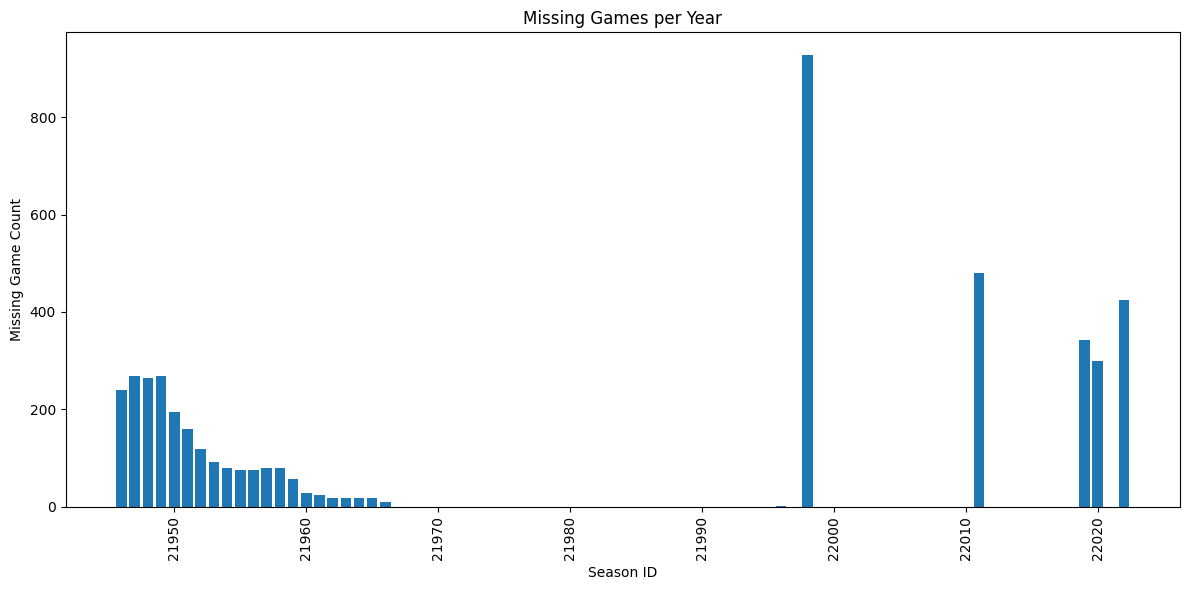

In [25]:
import matplotlib.pyplot as plt 

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Get unique team IDs
unique_team_ids = set(data['team_id_home'].unique()).union(set(data['team_id_away'].unique()))

# Define the expected number of games in a season (adjust according to your data)
expected_games_per_season = 82

# Create dictionaries to store missing game counts per team and year
missing_games_per_team = {}
missing_games_per_year = {}

# Iterate over each team ID
for team_id in unique_team_ids:
    # Retrieve unique season IDs for the specified team (both home and away games)
    team_season_ids_home = data.loc[data['team_id_home'] == team_id, 'season_id'].unique()
    team_season_ids_away = data.loc[data['team_id_away'] == team_id, 'season_id'].unique()
    team_season_ids = set(team_season_ids_home).union(set(team_season_ids_away))

    # Iterate through each season ID for the specified team
    for season_id in team_season_ids:
        # Retrieve unique game IDs for the current team and season (both home and away games)
        team_season_games_home = data.loc[(data['team_id_home'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games_away = data.loc[(data['team_id_away'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games = set(team_season_games_home).union(set(team_season_games_away))

        # Check if the count of unique game IDs is less than the expected number of games
        if len(team_season_games) < expected_games_per_season:
            missing_games = expected_games_per_season - len(team_season_games)

            # Update missing game count per team
            if team_id in missing_games_per_team:
                missing_games_per_team[team_id] += missing_games
            else:
                missing_games_per_team[team_id] = missing_games

            # Update missing game count per year
            if season_id in missing_games_per_year:
                missing_games_per_year[season_id] += missing_games
            else:
                missing_games_per_year[season_id] = missing_games

# Create lists for season IDs and missing game counts
season_ids = list(missing_games_per_year.keys())
missing_game_counts_per_year = list(missing_games_per_year.values())

# Plot the amount of missing games per year
plt.figure(figsize=(12, 6))
plt.bar(season_ids, missing_game_counts_per_year)
plt.xlabel('Season ID')
plt.ylabel('Missing Game Count')
plt.title('Missing Games per Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

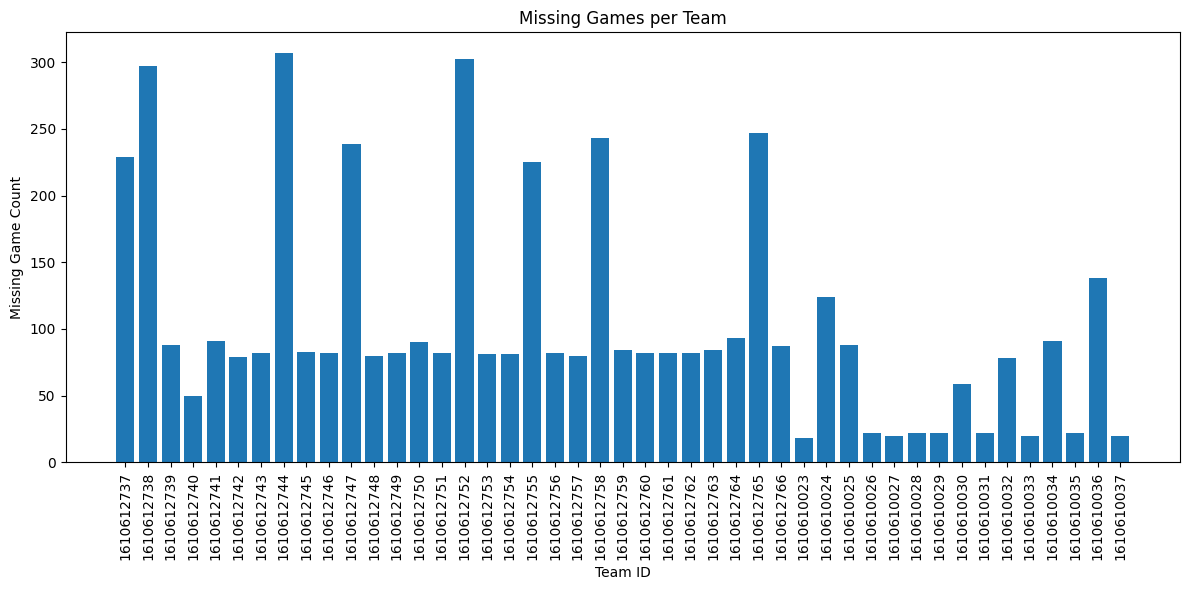

In [49]:
import matplotlib.pyplot as plt

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Get unique team IDs
unique_team_ids = set(data['team_id_home'].unique()).union(set(data['team_id_away'].unique()))

# Define the expected number of games in a season (adjust according to your data)
expected_games_per_season = 82

# Create dictionaries to store missing game counts per team and year
missing_games_per_team = {}
missing_games_per_year = {}

# Iterate over each team ID
for team_id in unique_team_ids:
    # Retrieve unique season IDs for the specified team (both home and away games)
    team_season_ids_home = data.loc[data['team_id_home'] == team_id, 'season_id'].unique()
    team_season_ids_away = data.loc[data['team_id_away'] == team_id, 'season_id'].unique()
    team_season_ids = set(team_season_ids_home).union(set(team_season_ids_away))

    # Iterate through each season ID for the specified team
    for season_id in team_season_ids:
        # Retrieve unique game IDs for the current team and season (both home and away games)
        team_season_games_home = data.loc[(data['team_id_home'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games_away = data.loc[(data['team_id_away'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games = set(team_season_games_home).union(set(team_season_games_away))

        # Check if the count of unique game IDs is less than the expected number of games
        if len(team_season_games) < expected_games_per_season:
            missing_games = expected_games_per_season - len(team_season_games)

            # Update missing game count per team
            if team_id in missing_games_per_team:
                missing_games_per_team[team_id] += missing_games
            else:
                missing_games_per_team[team_id] = missing_games

            # Update missing game count per year
            if season_id in missing_games_per_year:
                missing_games_per_year[season_id] += missing_games
            else:
                missing_games_per_year[season_id] = missing_games

# Create lists for team IDs and missing game counts
team_ids = list(missing_games_per_team.keys())
missing_game_counts = list(missing_games_per_team.values())

plt.figure(figsize=(12, 6))
plt.bar(range(len(team_ids)), missing_game_counts)
plt.xlabel('Team ID')
plt.ylabel('Missing Game Count')
plt.title('Missing Games per Team')
plt.xticks(range(len(team_ids)), team_ids, rotation=90)
plt.tight_layout()
plt.show()

#Probably all the oldest team have more "missing" games because in the beginnign in 1940s there were no fixed amount of games

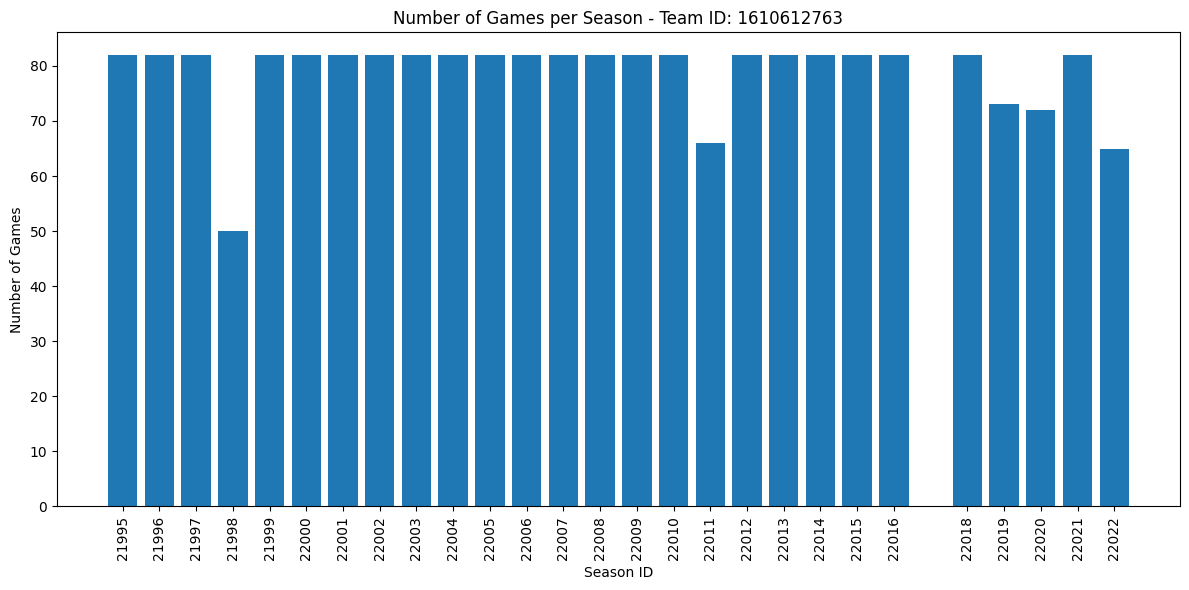

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Define the team ID for which you want to plot the games
team_id = 1610612763  # Replace with the desired team ID

# Filter the data for the specified team
team_data = data[(data['team_id_home'] == team_id) | (data['team_id_away'] == team_id)]

# Get unique season IDs for the specified team
team_season_ids = team_data['season_id'].unique()

# Count the number of games played by the team in each season
games_per_season = team_data['season_id'].value_counts()

# Create a bar plot for the games per season
plt.figure(figsize=(12, 6))
plt.bar(games_per_season.index, games_per_season.values)
plt.xlabel('Season ID')
plt.ylabel('Number of Games')
plt.title(f'Number of Games per Season - Team ID: {team_id}')
plt.xticks(team_season_ids, rotation=90)
plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
    SELECT
    team_name_home,
    team_name_away,
    plus_minus_away,
    game_date
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    WHERE game_date='2003-04-16'
'''
    
result = con.execute(query2)
data = result.fetchdf()

print(data)


           team_name_home          team_name_away  plus_minus_away  game_date
0          Boston Celtics         Detroit Pistons               -7 2003-04-16
1     Cleveland Cavaliers         Toronto Raptors              -10 2003-04-16
2     New Orleans Hornets           Atlanta Hawks              -15 2003-04-16
3     Seattle SuperSonics            Phoenix Suns              -14 2003-04-16
4          Denver Nuggets         Houston Rockets                5 2003-04-16
5       Memphis Grizzlies  Minnesota Timberwolves                8 2003-04-16
6       San Antonio Spurs        Dallas Mavericks               21 2003-04-16
7        Sacramento Kings               Utah Jazz              -11 2003-04-16
8          Indiana Pacers         New Jersey Nets               -7 2003-04-16
9      Philadelphia 76ers      Washington Wizards              -20 2003-04-16
10   Los Angeles Clippers  Portland Trail Blazers              -14 2003-04-16
11  Golden State Warriors      Los Angeles Lakers               

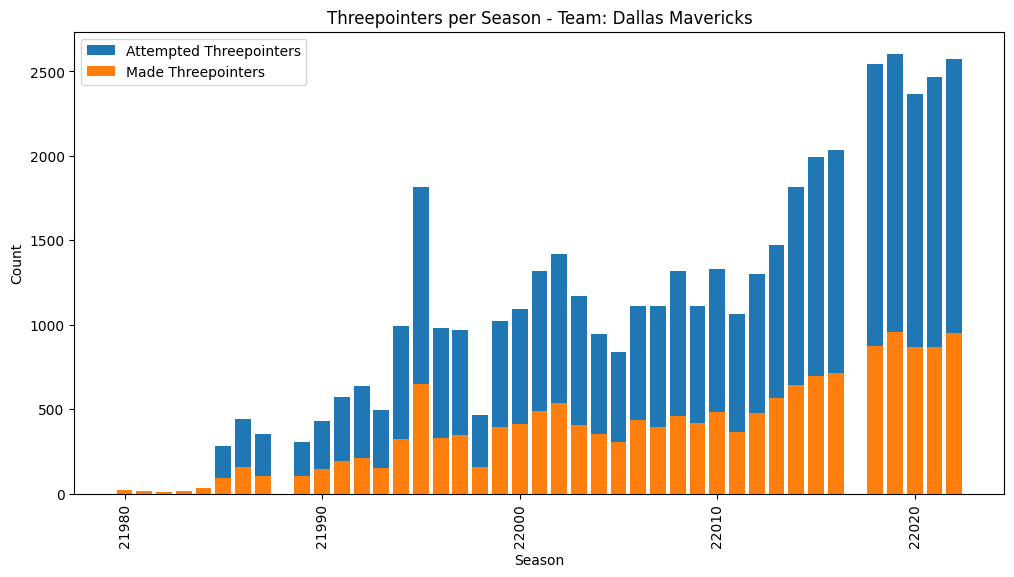

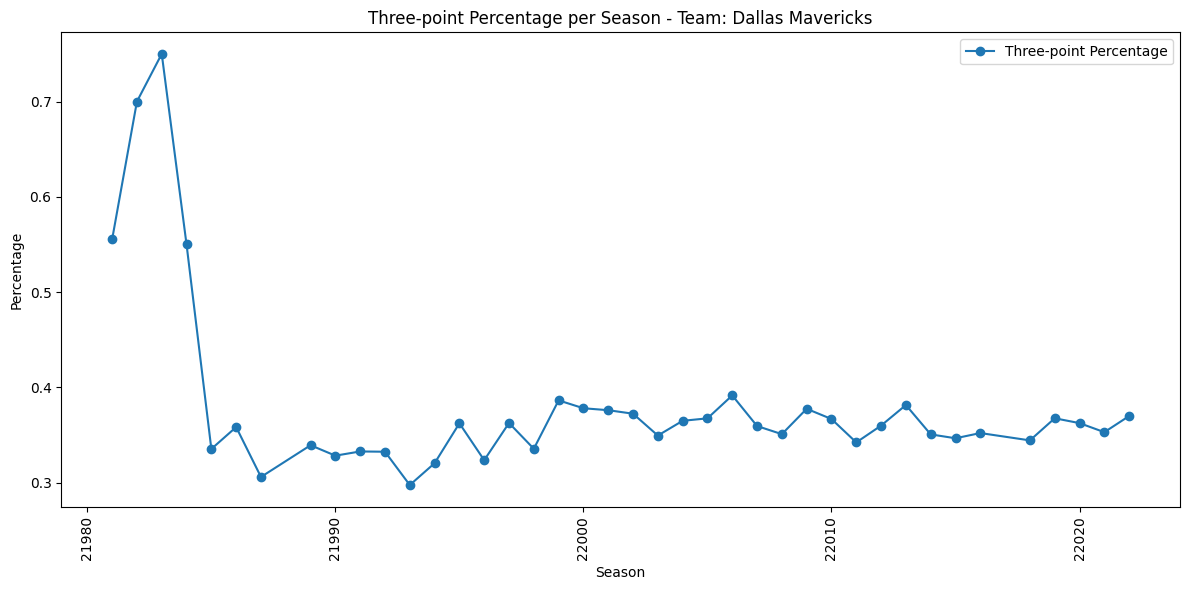

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import random

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
   SELECT 
        SEASON_ID AS season,
        TEAM_ID_HOME AS team_id,
        TEAM_NAME_HOME AS team_name,
        FG3m_HOME AS made_threepointers,
        FG3a_HOME AS attempted_threepointers,
        FG3_PCT_HOME AS three_point_percentage,
        COUNT(TEAM_ID_HOME) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_HOME, TEAM_NAME_HOME, FG3_PCT_HOME, FG3m_HOME, FG3a_HOME
    
    UNION
    
    SELECT 
        SEASON_ID AS season,
        TEAM_ID_AWAY AS team_id,
        TEAM_NAME_AWAY AS team_name,        
        FG3m_AWAY AS made_threepointers,
        FG3a_AWAY AS attempted_threepointers,
        FG3_PCT_AWAY AS three_point_percentage,
        COUNT(TEAM_ID_AWAY) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_AWAY, TEAM_NAME_AWAY, FG3_PCT_AWAY, FG3m_AWAY, FG3a_AWAY
'''
    
result = con.execute(query2)
data = result.fetchdf()

team_ids = list(set(data['team_id']))
# Select one random team ID
random_team_id = random.choice(team_ids)

# Filter the DataFrame for the selected team
random_team = data[data['team_id'] == random_team_id]

# Group by season and sum the made and attempted threepointers
grouped_df1 = random_team.groupby('season').agg({'attempted_threepointers': 'sum', 'made_threepointers': 'sum'}).reset_index()
grouped_df2 = random_team.groupby('season').agg({'three_point_percentage': 'mean'}).reset_index()

# Plot stacked bar plot for made and attempted threepointers per season
plt.figure(figsize=(12, 6))
plt.bar(grouped_df1['season'], grouped_df1['attempted_threepointers'], label='Attempted Threepointers')
plt.bar(grouped_df1['season'], grouped_df1['made_threepointers'], label='Made Threepointers')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Threepointers per Season - Team: {}'.format(random_team['team_name'].values[0]))
plt.legend()
plt.xticks(rotation=90)

# Line plot for three_point_percentage
plt.figure(figsize=(12, 6))
plt.plot(grouped_df2['season'], grouped_df2['three_point_percentage'], marker='o', label='Three-point Percentage')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.title('Three-point Percentage per Season - Team: {}'.format(random_team['team_name'].values[0]))
plt.legend()
plt.xticks(rotation=90)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


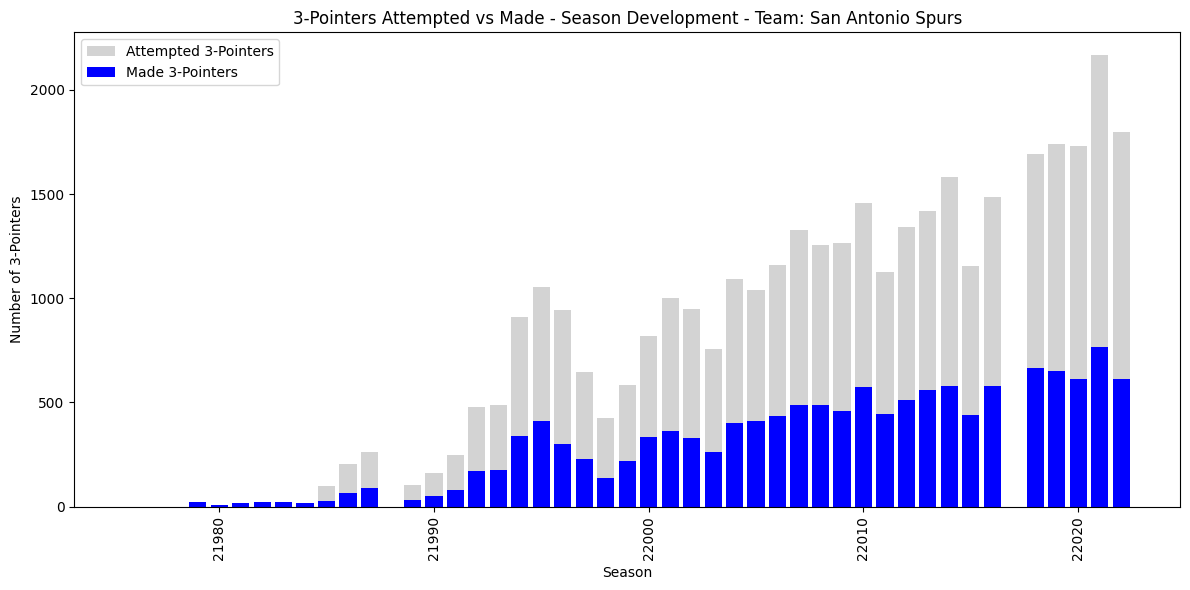

In [120]:
# Your code to fetch the data and select a random team
import pandas as pd
import matplotlib.pyplot as plt
import random

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
   SELECT 
        SEASON_ID AS season,
        TEAM_ID_HOME AS team_id,
        TEAM_NAME_HOME AS team_name,
        FG3m_HOME AS made_threepointers,
        FG3a_HOME AS attempted_threepointers,
        FG3_PCT_HOME AS three_point_percentage,
        COUNT(TEAM_ID_HOME) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_HOME, TEAM_NAME_HOME, FG3_PCT_HOME, FG3m_HOME, FG3a_HOME
    
    UNION
    
    SELECT 
        SEASON_ID AS season,
        TEAM_ID_AWAY AS team_id,
        TEAM_NAME_AWAY AS team_name,        
        FG3m_AWAY AS made_threepointers,
        FG3a_AWAY AS attempted_threepointers,
        FG3_PCT_AWAY AS three_point_percentage,
        COUNT(TEAM_ID_AWAY) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_AWAY, TEAM_NAME_AWAY, FG3_PCT_AWAY, FG3m_AWAY, FG3a_AWAY
'''
    
result = con.execute(query2)
data = result.fetchdf()

team_ids = list(set(data['team_id']))
# Select one random team ID
random_team_id = random.choice(team_ids)


# Filter the DataFrame for the selected team
random_team = data[data['team_id'] == random_team_id]

# Group the data by season and calculate the sum of attempted and made 3-pointers
season_data = random_team.groupby('season').agg({'attempted_threepointers': 'sum', 'made_threepointers': 'sum'}).reset_index()

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))

# Plot the background bar for attempted 3-pointers
plt.bar(season_data['season'], season_data['attempted_threepointers'], color='lightgray', label='Attempted 3-Pointers')

# Plot the foreground bar for made 3-pointers on top
plt.bar(season_data['season'], season_data['made_threepointers'], color='blue', label='Made 3-Pointers')

plt.xlabel('Season')
plt.ylabel('Number of 3-Pointers')
plt.title('3-Pointers Attempted vs Made - Season Development - Team: {}'.format(random_team['team_name'].values[0]))
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


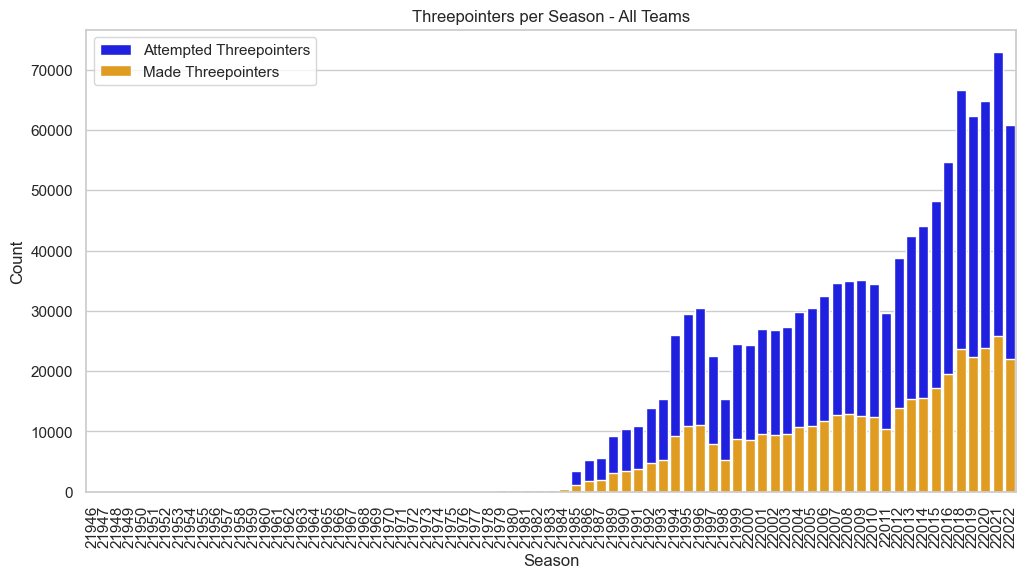

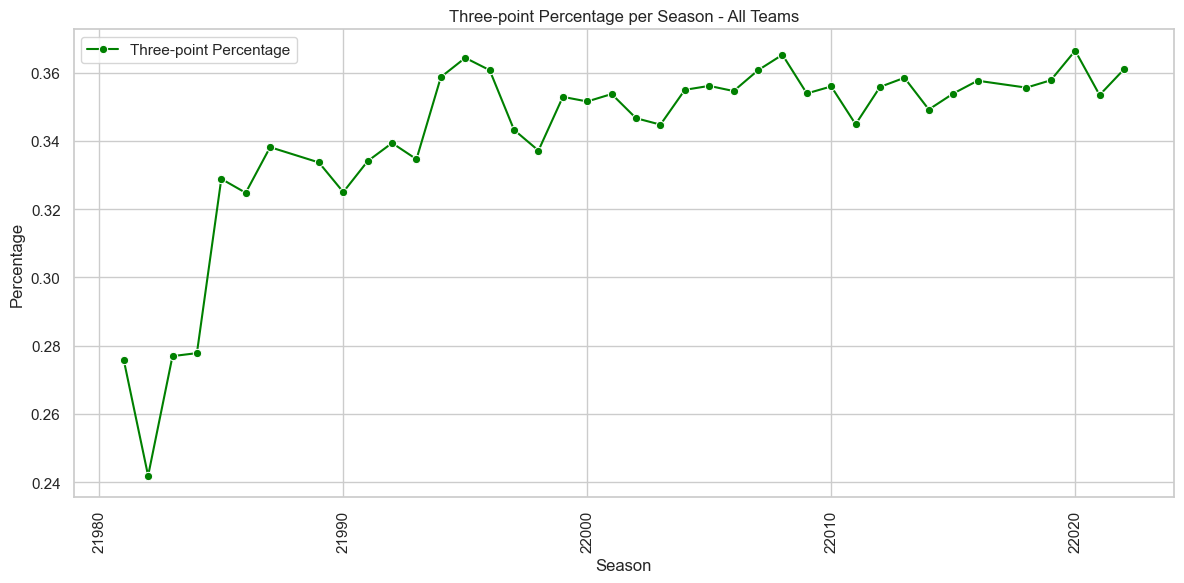

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
   SELECT 
        SEASON_ID AS season,
        TEAM_ID_HOME AS team_id,
        TEAM_NAME_HOME AS team_name,
        FG3m_HOME AS made_threepointers,
        FG3a_HOME AS attempted_threepointers,
        FG3_PCT_HOME AS three_point_percentage,
        COUNT(TEAM_ID_HOME) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_HOME, TEAM_NAME_HOME, FG3_PCT_HOME, FG3m_HOME, FG3a_HOME
    
    UNION
    
    SELECT 
        SEASON_ID AS season,
        TEAM_ID_AWAY AS team_id,
        TEAM_NAME_AWAY AS team_name,        
        FG3m_AWAY AS made_threepointers,
        FG3a_AWAY AS attempted_threepointers,
        FG3_PCT_AWAY AS three_point_percentage,
        COUNT(TEAM_ID_AWAY) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_AWAY, TEAM_NAME_AWAY, FG3_PCT_AWAY, FG3m_AWAY, FG3a_AWAY
'''
    
result = con.execute(query2)
data = result.fetchdf()

# Group by season and sum the made and attempted threepointers for all teams
grouped_df1 = data.groupby('season').agg({'attempted_threepointers': 'sum', 'made_threepointers': 'sum'}).reset_index()
grouped_df2 = data.groupby('season').agg({'three_point_percentage': 'mean'}).reset_index()

# Set the Seaborn style
sns.set(style='whitegrid')

# Plot stacked bar plot for made and attempted threepointers per season
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df1, x='season', y='attempted_threepointers', color='blue', label='Attempted Threepointers')
sns.barplot(data=grouped_df1, x='season', y='made_threepointers', color='orange', label='Made Threepointers')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Threepointers per Season - All Teams')
plt.legend()
plt.xticks(rotation=90)

# Line plot for three_point_percentage
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_df2, x='season', y='three_point_percentage', marker='o', color='green', label='Three-point Percentage')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.title('Three-point Percentage per Season - All Teams')
plt.legend()
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


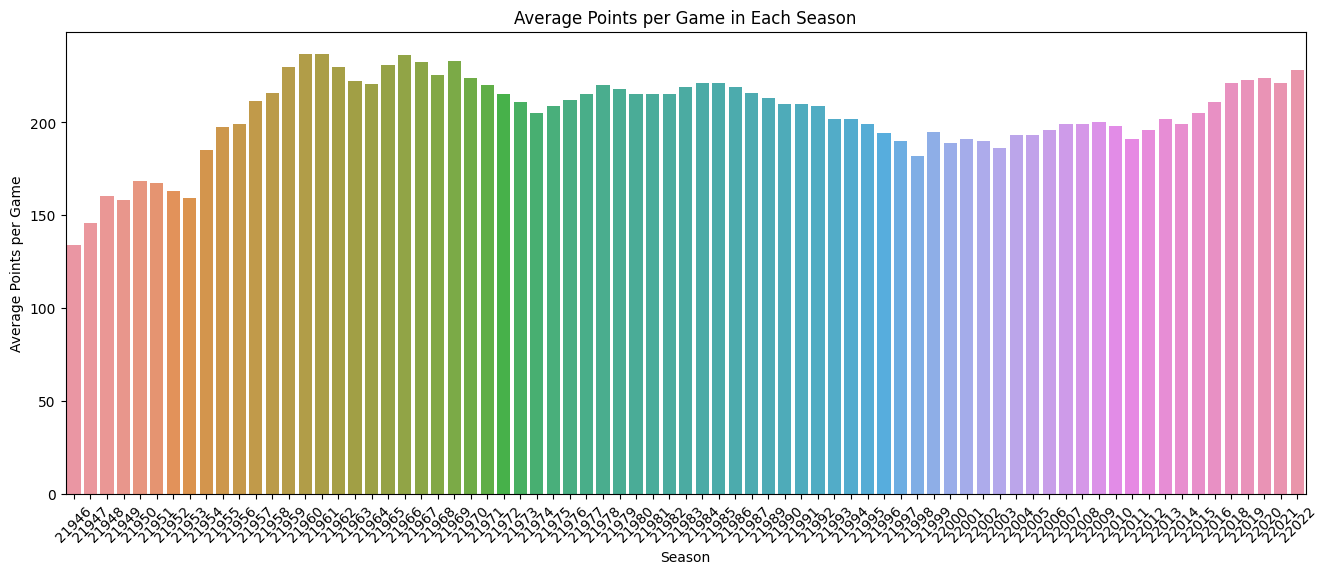

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

con = duckdb.connect(database=':memory:', read_only=False)

query = '''
    SELECT season_id, pts_home, pts_away
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query)
data = result.fetchdf()


# Calculate average points per game
data['avg_points'] = (data['pts_home'] + data['pts_away'])

# Group by season_id and calculate the mean average points
season_avg_points = data.groupby('season_id')['avg_points'].median().reset_index()

# Create the bar plot using seaborn
plt.figure(figsize=(16, 6))
sns.barplot(x='season_id', y='avg_points', data=season_avg_points)
plt.xlabel('Season')
plt.ylabel('Average Points per Game')
plt.title('Average Points per Game in Each Season')
plt.xticks(rotation=45)
plt.show()


In [48]:
print(data[data['season_id'] == 21986].mean())

season_id     21986.000000
pts_home      112.519618  
pts_away      107.351007  
avg_points    219.870626  
dtype: float64


In [139]:
#Exploration
import pandas as pd
import matplotlib.pyplot as plt
import random

con = duckdb.connect(database=':memory:', read_only=False)

query2 = '''
   SELECT 
        GAME_ID as game_id,
        SEASON_ID AS season,
        TEAM_ID_HOME AS team_id,
        TEAM_NAME_HOME AS team_name,
        FG3m_HOME AS made_threepointers,
        FG3a_HOME AS attempted_threepointers,
        FG3_PCT_HOME AS three_point_percentage,
        COUNT(TEAM_ID_HOME) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY GAME_ID, SEASON_ID, TEAM_ID_HOME, TEAM_NAME_HOME, FG3_PCT_HOME, FG3m_HOME, FG3a_HOME, 
    
    UNION
    
    SELECT
        GAME_ID AS game_id,
        SEASON_ID AS season,
        TEAM_ID_AWAY AS team_id,
        TEAM_NAME_AWAY AS team_name,        
        FG3m_AWAY AS made_threepointers,
        FG3a_AWAY AS attempted_threepointers,
        FG3_PCT_AWAY AS three_point_percentage,
        COUNT(TEAM_ID_AWAY) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY GAME_ID, SEASON_ID, TEAM_ID_AWAY, TEAM_NAME_AWAY, FG3_PCT_AWAY, FG3m_AWAY, FG3a_AWAY
'''
    
result = con.execute(query2)
data = result.fetchdf()

data['game_id'] = data['game_id'].astype(str)
# Filter the data for the desired games
game_ids = ['0028100002', '0020000006', '0021500018', '0021500003' ]
filtered_data = data[data['game_id'].isin(game_ids)]

# Calculate the three-point percentage for each game
filtered_data['calculated_percentage'] = (filtered_data['made_threepointers'] / filtered_data['attempted_threepointers']).round(decimals=3)

# Compare the calculated percentage with the inbuilt percentage
filtered_data['comparison'] = filtered_data['calculated_percentage'] == filtered_data['three_point_percentage']

# Reset the index to have a flat DataFrame
filtered_data = filtered_data.reset_index(drop=True)

# Print the data to analyze the comparison
with pd.option_context('mode.chained_assignment', None):  # Disable the warning
    filtered_data.loc[:, 'comparison'] = filtered_data['comparison'].astype(bool)

    # Adjust cell output settings to display all columns
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)

    print(filtered_data)

      game_id  season     team_id               team_name  made_threepointers  attempted_threepointers  three_point_percentage  team_game_count  calculated_percentage  comparison
0  0021500018   22015  1610612754          Indiana Pacers                12.0                     30.0                   0.400                1                  0.400        True
1  0021500003   22015  1610612744   Golden State Warriors                 9.0                     30.0                   0.300                1                  0.300        True
2  0020000006   22000  1610612741           Chicago Bulls                 6.0                      8.0                   0.750                1                  0.750        True
3  0021500003   22015  1610612740    New Orleans Pelicans                 6.0                     18.0                   0.333                1                  0.333        True
4  0028100002   21981  1610612757  Portland Trail Blazers                 0.0                      NaN   

C:\Users\Yoric\AppData\Local\Temp\ipykernel_20112\3605342974.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Yoric\AppData\Local\Temp\ipykernel_20112\3605342974.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
import duckdb
import pandas as pd

con = duckdb.connect(database=':memory:', read_only=False)

query1 = '''
    SELECT person_id, first_name, last_name, draft_round, draft_number, draft_year
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/common_player_info.csv')
    WHERE draft_year = '2009'
    ORDER BY draft_round, draft_number
'''

query2 = '''
    SELECT game_id, eventmsgtype, eventmsgactiontype, homedescription, visitordescription, player1_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/play_by_play.csv')
    WHERE eventmsgtype = 2
'''

query3 = '''
    SELECT person_id, season as season_id, player_name
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/draft_history.csv')
    WHERE season = 2009
'''

query4 = '''
    SELECT game_id, eventmsgtype, eventmsgactiontype, homedescription, visitordescription, player1_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/play_by_play.csv')
    WHERE eventmsgtype = 1
'''
    
query5 = '''
    SELECT game_id, season_id-20000 as season_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    WHERE season_id > 22008
'''

result = con.execute(query2)
data = result.fetchdf()
action_types = [1, 2, 5, 3, 45, 46, 47, 40, 59, 63, 66, 44, 80, 79, 78, 84, 86, 81, 95, 83, 85, 77, 103, 104, 82, 101, 105, 96, 72, 102]
filtered_data_miss = data[~data['eventmsgactiontype'].isin(action_types)]  # Exclude eventmsgactiontype values in action_types

result2 = con.execute(query4)
data2 = result2.fetchdf()
filtered_data_made = data2[~data2['eventmsgactiontype'].isin(action_types)]  # Exclude eventmsgactiontype values in action_types

players = con.execute(query1)
players_data = pd.DataFrame(players.fetch_df())
players_other = con.execute(query3)
players_other_data = pd.DataFrame(players_other.fetch_df())

# Perform the merge if the 'person_id' column is present in both DataFrames
joined_df = players_other_data.merge(players_data, how='outer', on='person_id')

filtered_data_made = filtered_data_made[filtered_data_made['player1_id'].isin(joined_df['person_id'])]
filtered_data_miss = filtered_data_miss[filtered_data_miss['player1_id'].isin(joined_df['person_id'])]

# Filter game IDs based on season
season_data = con.execute(query5).fetch_df()
filtered_game_ids = season_data['game_id']

# Merge filtered_data_made with season_data
filtered_data_made = filtered_data_made.merge(season_data, how='inner', on='game_id')

# Merge filtered_data_miss with season_data
filtered_data_miss = filtered_data_miss.merge(season_data, how='inner', on='game_id')

# Merge filtered_data_made and filtered_data_miss to create a combined DataFrame
combined_data = pd.concat([filtered_data_made, filtered_data_miss])

# Perform the merge if the 'player1_id' and 'season_id' columns are present in both DataFrames
merged_data = combined_data.merge(joined_df, how='left', left_on='player1_id', right_on='person_id')

# Count unique game appearances for made and missed shots
game_counts = merged_data.groupby(['player1_id', 'season_id_x'])['game_id'].nunique().reset_index()

# Count total shot attempts per player and season
attempt_counts = merged_data.groupby(['player1_id', 'season_id_x'])['player1_id'].size()
attempt_counts.columns = ['player_id', 'season_id_x', 'attempted_shots']

# Count made shots per player and season
made_counts = filtered_data_made.groupby(['player1_id', 'season_id'])['player1_id'].size()
made_counts.columns = ['player_id', 'season_id', 'made_shots']

#made_counts['player1_id'] = made_counts.index
shot_counts = pd.concat([attempt_counts, made_counts], axis=1, keys=['attempt', 'made'])

# Calculate shot percentage as made shots divided by attempted shots
shot_counts['shot_percentage'] = shot_counts['made'] / shot_counts['attempt']

shot_counts.reset_index(inplace=True)
#shot_counts = shot_counts.pivot(index='player1_id', columns='level_1')

# Merge game counts, shot counts, and joined_df
player_game_stats2PT = pd.merge(game_counts, shot_counts, right_on=['player1_id', 'level_1'], left_on=['player1_id', 'season_id_x'], how='outer')
player_game_stats2PT = pd.merge(player_game_stats2PT, joined_df, how='left', left_on='player1_id', right_on='person_id')

print(player_game_stats2PT)


     player1_id  season_id_x  game_id  level_1  attempt   made  \
0    201933      2010         75       2010     389      296.0   
1    201933      2011         61       2011     313      257.0   
2    201933      2012         73       2012     303      257.0   
3    201933      2013         73       2013     358      294.0   
4    201933      2014         65       2014     233      175.0   
5    201933      2015         33       2015     124      101.0   
6    201933      2016         59       2016     268      201.0   
7    201933      2018         72       2018     380      242.0   
8    201933      2019         16       2019     51       30.0    
9    201933      2020         40       2020     106      68.0    
10   201933      2021         43       2021     99       58.0    
11   201933      2022         16       2022     38       28.0    
12   201934      2009         27       2009     46       36.0    
13   201934      2010         16       2010     18       11.0    
14   20193

In [60]:
result = con.execute(query5)
data = result.fetchdf()

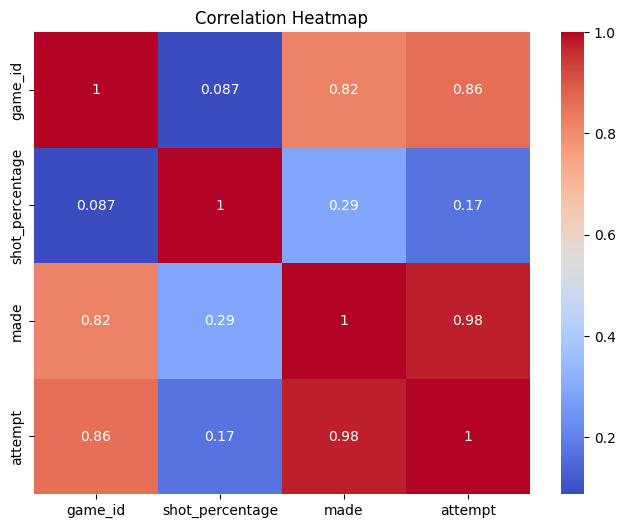

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the numeric columns for correlation
numeric_columns = ['game_id', 'shot_percentage', 'made', 'attempt']

# Subset the DataFrame with the numeric columns
numeric_data = player_game_stats2PT[numeric_columns]

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [99]:
import duckdb
import pandas as pd

con = duckdb.connect(database=':memory:', read_only=False)

query1 = '''
    SELECT person_id, first_name, last_name, draft_round, draft_number, draft_year
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/common_player_info.csv')
    WHERE draft_year = '2009'
    ORDER BY draft_round, draft_number
'''

query2 = '''
    SELECT game_id, eventmsgtype, eventmsgactiontype, homedescription, visitordescription, player1_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/play_by_play.csv')
    WHERE eventmsgtype = 2
'''

query3 = '''
    SELECT person_id, season as season_id, player_name
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/draft_history.csv')
    WHERE season = 2009
'''

query4 = '''
    SELECT game_id, eventmsgtype, eventmsgactiontype, homedescription, visitordescription, player1_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/play_by_play.csv')
    WHERE eventmsgtype = 1
'''
    
query5 = '''
    SELECT game_id, season_id-20000 as season_id
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    WHERE season_id > 22008 AND season_id < 22015
'''

result = con.execute(query2)
data = result.fetchdf()
action_types = [1, 2, 5, 3, 45, 46, 47, 40, 59, 63, 66, 44, 80, 79, 78, 84, 86, 81, 95, 83, 85, 77, 103, 104, 82, 101, 105, 96, 72, 102]
filtered_data_miss = data[data['eventmsgactiontype'].isin(action_types)]

result2 = con.execute(query4)
data2 = result2.fetchdf()
filtered_data_made = data2[data2['eventmsgactiontype'].isin(action_types)]

players = con.execute(query1)
players_data = pd.DataFrame(players.fetch_df())
players_other = con.execute(query3)
players_other_data = pd.DataFrame(players_other.fetch_df())

# Perform the merge if the 'person_id' column is present in both DataFrames
joined_df = players_other_data.merge(players_data, how='outer', on='person_id')

filtered_data_made = filtered_data_made[filtered_data_made['player1_id'].isin(joined_df['person_id'])]
filtered_data_miss = filtered_data_miss[filtered_data_miss['player1_id'].isin(joined_df['person_id'])]

# Filter game IDs based on season
season_data = con.execute(query5).fetch_df()
filtered_game_ids = season_data['game_id']

# Merge filtered_data_made with season_data
filtered_data_made = filtered_data_made.merge(season_data, how='inner', on='game_id')

# Merge filtered_data_miss with season_data
filtered_data_miss = filtered_data_miss.merge(season_data, how='inner', on='game_id')

# Merge filtered_data_made and filtered_data_miss to create a combined DataFrame
combined_data = pd.concat([filtered_data_made, filtered_data_miss])

# Perform the merge if the 'player1_id' and 'season_id' columns are present in both DataFrames
merged_data = combined_data.merge(joined_df, how='left', left_on='player1_id', right_on='person_id')

# Count unique game appearances for made and missed shots
game_counts = merged_data.groupby(['player1_id', 'season_id_x'])['game_id'].nunique().reset_index()

# Count total shot attempts per player and season
attempt_counts = merged_data.groupby(['player1_id', 'season_id_x'])['player1_id'].size()
attempt_counts.columns = ['player_id', 'season_id_x', 'attempted_shots']

# Count made shots per player and season
made_counts = filtered_data_made.groupby(['player1_id', 'season_id'])['player1_id'].size()
made_counts.columns = ['player_id', 'season_id', 'made_shots']

#made_counts['player1_id'] = made_counts.index
shot_counts = pd.concat([attempt_counts, made_counts], axis=1, keys=['attempt', 'made'])

shot_counts.reset_index(inplace=True)

# Assuming df is your DataFrame with columns 'season_id', 'attempt', and 'made'
shot_counts['attempt_zscore'] = (shot_counts['attempt'] - shot_counts.groupby('level_1')['attempt'].transform('mean')) / \
                        shot_counts.groupby('level_1')['attempt'].transform('std')

shot_counts['made_zscore'] = (shot_counts['made'] - shot_counts.groupby('level_1')['made'].transform('mean')) / \
                     shot_counts.groupby('level_1')['made'].transform('std')

shot_counts['z_score_shot_percentage'] = shot_counts['made_zscore'] / shot_counts['attempt_zscore']

# Calculate shot percentage as made shots divided by attempted shots
shot_counts['shot_percentage'] = shot_counts['made'] / shot_counts['attempt']

#shot_counts = shot_counts.pivot(index='player1_id', columns='level_1')

# Merge game counts, shot counts, and joined_df
player_game_stats3PT = pd.merge(game_counts, shot_counts, right_on=['player1_id', 'level_1'], left_on=['player1_id', 'season_id_x'], how='outer')
player_game_stats3PT = pd.merge(player_game_stats3PT, joined_df, how='left', left_on='player1_id', right_on='person_id')

print(player_game_stats3PT)

In [97]:
import plotly.express as px

# Assuming your dataset is stored in a DataFrame called 'player_game_stats3PT'
shot_percentage = player_game_stats3PT['shot_percentage']
z_score_shot_percentage = player_game_stats3PT['z_score_shot_percentage']
player_names = player_game_stats3PT['player_name']
season_ids = player_game_stats3PT['level_1']

# Create a scatter plot using Plotly Express
fig = px.scatter(player_game_stats3PT, x=shot_percentage, y=z_score_shot_percentage,
                 hover_data={'player_name': True, 'level_1': True})

# Update the hover tooltip labels
fig.update_traces(text=[f"{name}, {season}" for name, season in zip(player_names, season_ids)])

# Customize axes labels and plot title
fig.update_layout(
    xaxis_title='Shot Percentage',
    yaxis_title='Z-Score Shot Percentage',
    title='Scatter Plot: Shot Percentage vs Z-Score Shot Percentage'
)

# Display the plot
fig.show()


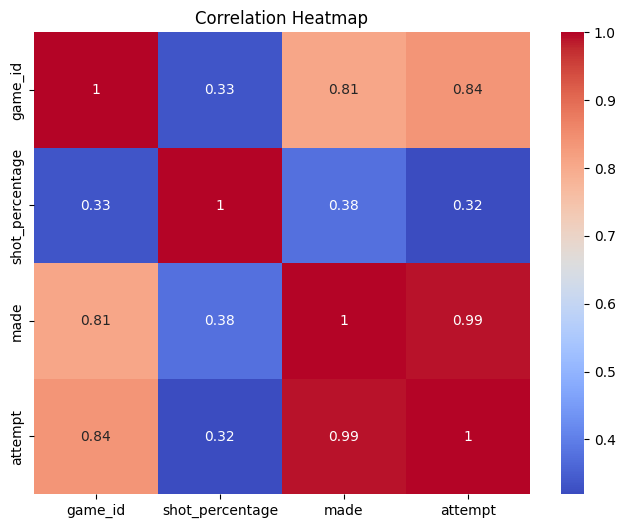

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the numeric columns for correlation
numeric_columns = ['game_id', 'shot_percentage', 'made', 'attempt']

# Subset the DataFrame with the numeric columns
numeric_data = player_game_stats3PT[numeric_columns]

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Findings:
    
    Missing two total seasons 1988 and 2017 

    only the games since the last team relocation are stored e. g. Golden State Warriors
        --> TeamID in the query solves this 
    investigate seasons 1998 further
    
    timely investigation reasonable since 1966 beforehand the were no fixed amount of games per team and year
    
    Season games are only in the table check it for another season then 02/03
    

In [98]:
players_to_consider = player_game_stats3PT
top_players = players_to_consider.sort_values('z_score_shot_percentage', ascending=False).groupby('season_id').head(30)
top_players.describe()

,player1_id,season_id_x,game_id,level_1,attempt,made,attempt_zscore,made_zscore,z_score_shot_percentage,shot_percentage,person_id,season_id
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0
mean,201960.833333,2013.400000,62.933333,2013.400000,422.333333,170.733333,0.056906,0.107510,2.289387,0.398328,201960.833333,2009.0
std,17.561877,3.233446,13.232492,3.233446,86.949186,50.404525,0.246595,0.434006,1.239865,0.056816,17.561877,0.0
min,201933.000000,2009.000000,32.000000,2009.000000,258.000000,74.000000,-0.382861,-0.567149,1.410042,0.286822,201933.000000,2009.0
25%,201943.500000,2011.000000,57.500000,2011.000000,357.750000,132.750000,-0.093891,-0.283527,1.510368,0.356165,201943.500000,2009.0
50%,201960.500000,2013.000000,66.000000,2013.000000,419.500000,172.500000,0.063532,0.180143,1.863998,0.410506,201960.500000,2009.0
75%,201972.500000,2016.000000,71.750000,2016.000000,476.000000,206.750000,0.177698,0.369956,2.442398,0.431637,201972.500000,2009.0
max,201988.000000,2021.000000,79.000000,2021.000000,619.000000,281.000000,0.572545,0.958456,6.092750,0.507109,201988.000000,2009.0


In [64]:
players_to_consider = player_game_stats2PT[player_game_stats2PT['attempt']>=40]
top_players = players_to_consider.sort_values('shot_percentage', ascending=False).groupby('season_id').head(30)
top_players 

,player1_id,season_id_x,game_id,level_1,attempt,made,shot_percentage,person_id,season_id,player_name,first_name,last_name,draft_round,draft_number,draft_year
194,201974,2010,31,2010,55,49.0,0.890909,201974,2009,Derrick Brown,NaN,NaN,NaN,NaN,NaN
176,201970,2010,38,2010,67,59.0,0.880597,201970,2009,Sam Young,Sam,Young,2,36,2009
170,201967,2013,32,2013,48,42.0,0.875000,201967,2009,Dante Cunningham,NaN,NaN,NaN,NaN,NaN
148,201962,2009,27,2009,44,38.0,0.863636,201962,2009,Toney Douglas,NaN,NaN,NaN,NaN,NaN
142,201961,2009,30,2009,41,35.0,0.853659,201961,2009,Wayne Ellington,Wayne,Ellington,1,28,2009
120,201956,2014,47,2014,94,80.0,0.851064,201956,2009,Omri Casspi,NaN,NaN,NaN,NaN,NaN
2,201933,2012,73,2012,303,257.0,0.848185,201933,2009,Blake Griffin,Blake,Griffin,1,1,2009
109,201954,2009,51,2009,97,82.0,0.845361,201954,2009,Darren Collison,NaN,NaN,NaN,NaN,NaN
195,201974,2011,49,2011,88,74.0,0.840909,201974,2009,Derrick Brown,NaN,NaN,NaN,NaN,NaN
113,201954,2013,57,2013,113,95.0,0.840708,201954,2009,Darren Collison,NaN,NaN,NaN,NaN,NaN
